 <center> <h1> <b> Pattern Recognition and Machine Learning (EE5607) </b> </h1> </center>

<b> Programming Assignment - 04 - Neural Networks</b>

<b> Instructions </b>
1. Plagiarism is strictly prohibited.
2. Delayed submissions will be penalized with a scaling factor of 0.5 per day.
3. Please DO NOT use any machine learning libraries unless and otherwise specified.



<b> Assignment on Neural Networks </b> <br>
This programming assignment gives you a chance to perform the classification task using neural networks. You will get to build a neural network from scratch and train and test it on a standard classification dataset. Further you will learn different tricks and techniques to train a neural network eficiently by observing few important issues and trying to overcome them. This includes observing the performance of the network for different activation functions and optimization algorithms. We will conclude with implementation of various regularization techniques and ResNet to overcome the problems of overfitting and vanishing gradients.

In [ ]:
#All imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections
import random
import gzip
import math

<b>  Part - (1) : Train a classification network from scratch </b> 
1. Load MNIST data and create train, test splits
2. Design a simple classification network


> Network should consists of three Dense Layers with 512 nodes. The same architecture is used throughout the assignment to understand the effect of hyper parameters.

> Use stochastic gradient descent optimization algorithm to update the parameters. You can use the learning rate suitable for the MNIST digit classification problem.

> Use ReLU activation function in the first two layers. Softmax activation function should be used at the last layer to get the posterior probability of the classes.






3. Train the network using MNIST training data and evaluate the performance on MNIST test data



In [ ]:
##################################################
#Load MNIST data.
##################################################

def load_mnist(filename, type, n_datapoints):
    # MNIST Images have 28*28 pixels dimension
    image_size = 28
    f = gzip.open(filename)
    
    if(type == 'image'):
        f.read(16)    # Skip Non-Image information
        buf = f.read(n_datapoints * image_size * image_size)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(n_datapoints, 1, image_size, image_size)
    elif(type == 'label'):
        f.read(8) # Skip Inessential information
        buf = f.read(n_datapoints)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        data = data.reshape(n_datapoints, 1)
    return data
  
# Training Dataset
train_size = 60000
test_size = 10000

X_train = load_mnist('train-images.gz', 'image', train_size)
Y_train = load_mnist('train-labels.gz', 'label', train_size)
X_test = load_mnist('test-images.gz', 'image', test_size)
Y_test = load_mnist('test-labels.gz', 'label', test_size)

# print("X_Train Shape:", X_train.shape)
# print("Y_Train Shape:", Y_train.shape)
# print("X_Test Shape:", X_test.shape)
# print("Y_Test Shape:", Y_test.shape)


##################################################
#Build the architecture
##################################################

#utility functions
def one_hot(a, num_classes):
  return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

# activation function and its derivative

def ReLU(x):
    return x * (x > 0)

def ReLU_prime(x):
    return 1. * (x > 0)

def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

def sigmoid_prime(value):
  return sigmoid(value)*(1 - sigmoid(value))

# loss function and its derivative
def mse(y_true, y_pred):
  return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
  return 2*(y_pred-y_true)/y_true.size;

##################################################
#Train the network
##################################################

x_train = X_train.reshape(X_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255

x_test = X_test.reshape(X_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255

y_train = one_hot(Y_train, 10)
y_test = one_hot(Y_test, 10)

print("Dataset for Training")

print("x_Train Shape:", x_train.shape)
print("y_Train Shape:", y_train.shape)
print("x_Test Shape:", x_test.shape)
print("y_Test Shape:", y_test.shape)

# Base class
class Layer:
  def __init__(self):
      self.input = None
      self.output = None

  def forward_propagation(self, input):
      raise NotImplementedError

  def backward_propagation(self, output_error, learning_rate):
      raise NotImplementedError

class FCLayer(Layer):
  def __init__(self, input_size, output_size):
    self.weights = np.random.rand(input_size, output_size) - 0.5
    self.bias = np.random.rand(1, output_size) - 0.5

  def forward_propagation(self, input_data):
    self.input = input_data
    self.output = np.dot(self.input, self.weights) + self.bias
    return self.output

  def backward_propagation(self, output_error_grad, learning_rate):
    input_error_grad = np.dot(output_error_grad, self.weights.T)
    weights_error_grad = np.dot(self.input.T, output_error_grad)

    self.weights -= learning_rate * weights_error_grad
    self.bias -= learning_rate * output_error_grad
    return input_error_grad

# inherit from base class Layer
class ActivationLayer(Layer):
  def __init__(self, activation, activation_prime):
    self.activation = activation
    self.activation_prime = activation_prime

  def forward_propagation(self, input_data):
    self.input = input_data
    self.output = self.activation(self.input)
    return self.output

  def backward_propagation(self, output_error, learning_rate):
    return self.activation_prime(self.input) * output_error

# Network design
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train)

        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

# network
net = Network()
net.add(FCLayer(784, 512))
net.add(ActivationLayer(ReLU, ReLU_prime))
net.add(FCLayer(512, 512))
net.add(ActivationLayer(ReLU, ReLU_prime))
net.add(FCLayer(512, 10))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=5, learning_rate=0.1)

Dataset for Training
x_Train Shape: (60000, 1, 784)
y_Train Shape: (60000, 10)
x_Test Shape: (10000, 1, 784)
y_Test Shape: (10000, 10)
epoch 1/5   error=0.185716
epoch 2/5   error=0.136947
epoch 3/5   error=0.096373
epoch 4/5   error=0.097835
epoch 5/5   error=0.091912


In [ ]:
##############################################
#Test Performance
##############################################

y_pred = net.predict(x_test)

<b> Part - (2) : Understanding activation functions </b>

In this part you will learn to use different activation functions for the classification task and compare their performances.

1. Train MNIST digit classification problem with different activation functions i.e. Sigmoid, Tanh, ReLU, LeakyReLU etc. You can stick to stochastic gradient descent optimization algorithm for this part
2. Report the accuray on MNIST test data for all the experiments. Write down your observations in the report.</br>
NOTE: You can use the classification network designed by you from scratch (or) you can build the model using pytorch.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

dataset = MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class reLUModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 512)
        # output layer
        self.linear3 = nn.Linear(512, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class sigmoidModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 512)
        # output layer
        self.linear3 = nn.Linear(512, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = torch.sigmoid(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = torch.sigmoid(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

class tanhModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 512)
        # output layer
        self.linear3 = nn.Linear(512, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = torch.tanh(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = torch.tanh(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

#leaky relu
class leakyReLUModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 512)
        # output layer
        self.linear3 = nn.Linear(512, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.leaky_relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.leaky_relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

input_size = 784
num_classes = 10

In [ ]:
##################################################
#Train the network with different activation functions
##################################################

#ReLU
print("Training with ReLU Activation:")
reLUmodel = reLUModel(input_size, out_size=num_classes)

to_device(reLUmodel, device)

history = [evaluate(reLUmodel, val_loader)]
# with learning rate : 0.5
history += fit(5, 0.5, reLUmodel, train_loader, val_loader)
# with learning rate : 0.1
history += fit(5, 0.1, reLUmodel, train_loader, val_loader)

reLUlosses = [x['val_loss'] for x in history]
reLU_acc = history[-1]['val_acc']

#leaky ReLU
print("Training with Leaky ReLU Activation:")
leakyReluModel = leakyReLUModel(input_size, out_size=num_classes)

to_device(leakyReluModel, device)

history = [evaluate(leakyReluModel, val_loader)]
# with learning rate : 0.5
history += fit(5, 0.5, leakyReluModel, train_loader, val_loader)
# with learning rate : 0.1
history += fit(5, 0.1, leakyReluModel, train_loader, val_loader)

leakyRelulosses = [x['val_loss'] for x in history]
leaky_acc = history[-1]['val_acc']

#tanh
print("Training with tanh Activation:")
tanhModel = tanhModel(input_size, out_size=num_classes)
to_device(tanhModel, device)

history = [evaluate(tanhModel, val_loader)]
# with learning rate : 0.5
history += fit(5, 0.5, tanhModel, train_loader, val_loader)
# with learning rate : 0.1
history += fit(5, 0.1, tanhModel, train_loader, val_loader)

tanhlosses = [x['val_loss'] for x in history]
tanh_acc = history[-1]['val_acc']

#sigmoid
print("Training with sigmoid Activation:")
sigmoidModel = sigmoidModel(input_size, out_size=num_classes)

to_device(sigmoidModel, device)

history = [evaluate(sigmoidModel, val_loader)]
# with learning rate : 0.5
history += fit(5, 0.5, sigmoidModel, train_loader, val_loader)
# with learning rate : 0.1
history += fit(5, 0.1, sigmoidModel, train_loader, val_loader)

sigmoidlosses = [x['val_loss'] for x in history]
sigmoid_acc = history[-1]['val_acc']

Training with ReLU Activation:
Epoch [0], val_loss: 1.6372, val_acc: 0.8322
Epoch [1], val_loss: 1.5610, val_acc: 0.9075
Epoch [2], val_loss: 1.5416, val_acc: 0.9246
Epoch [3], val_loss: 1.5239, val_acc: 0.9422
Epoch [4], val_loss: 1.5127, val_acc: 0.9533
Epoch [0], val_loss: 1.5077, val_acc: 0.9567
Epoch [1], val_loss: 1.5061, val_acc: 0.9584
Epoch [2], val_loss: 1.5050, val_acc: 0.9594
Epoch [3], val_loss: 1.5037, val_acc: 0.9594
Epoch [4], val_loss: 1.5029, val_acc: 0.9619
Training with Leaky ReLU Activation:
Epoch [0], val_loss: 1.6285, val_acc: 0.8381
Epoch [1], val_loss: 1.6156, val_acc: 0.8473
Epoch [2], val_loss: 1.5460, val_acc: 0.9208
Epoch [3], val_loss: 1.5230, val_acc: 0.9412
Epoch [4], val_loss: 1.5150, val_acc: 0.9493
Epoch [0], val_loss: 1.5088, val_acc: 0.9547
Epoch [1], val_loss: 1.5080, val_acc: 0.9556
Epoch [2], val_loss: 1.5069, val_acc: 0.9568
Epoch [3], val_loss: 1.5053, val_acc: 0.9602
Epoch [4], val_loss: 1.5049, val_acc: 0.9600
Training with tanh Activation:
E

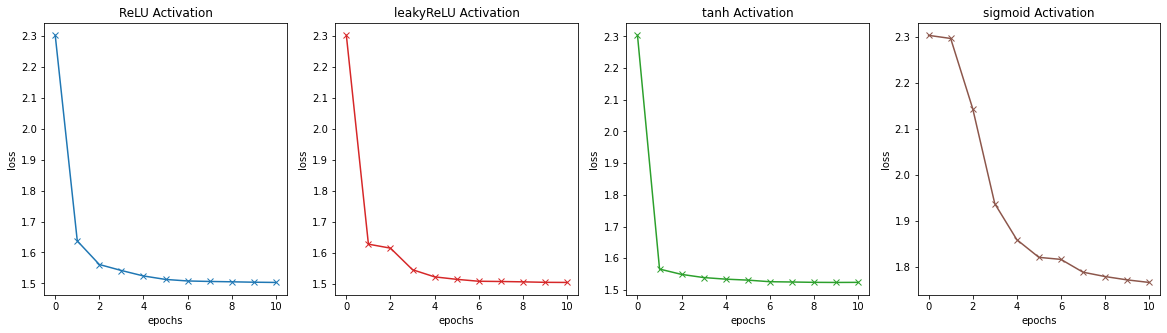

Validation Accuracy with ReLU :  0.9619140625
Validation Accuracy with Leaky ReLU :  0.9599609375
Validation Accuracy with tanh :  0.938769519329071
Validation Accuracy with sigmoid :  0.70947265625


In [ ]:
##################################################
#Write down the accuracies and report your observations
##################################################

plt.figure(figsize = (20,5))

plt.subplot(1,4,1)
plt.plot(reLUlosses, '-x', color ='tab:blue')
plt.title('ReLU Activation')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,4,2)
plt.plot(leakyRelulosses, '-x', color ='tab:red')
plt.title('leakyReLU Activation')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,4,3)
plt.plot(tanhlosses, '-x', color ='tab:green')
plt.title('tanh Activation')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,4,4)
plt.plot(sigmoidlosses, '-x', color ='tab:brown')
plt.title('sigmoid Activation')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

print("Validation Accuracy with ReLU : ", reLU_acc)
print("Validation Accuracy with Leaky ReLU : ", leaky_acc)
print("Validation Accuracy with tanh : ", tanh_acc)
print("Validation Accuracy with sigmoid : ", sigmoid_acc)

## Observation Report
Upon noting the loss values for each activation functions, we can observe that for ReLU, LeakyReLU and tanh activation function, model gives almost equal accuracies of around 95%. With sigmoid activation, outputs are limited between 0 to 1 and hence accuracy reduces drastically due to the lost of relevant information.

<b> Part - (3) : Understanding optimization algorithms </b>

In this part you will learn to use different optimiztion algorithm apart from SGD.

1. Using the best activation function from Part - (2), train the classification network using Adam optimization algorithm.
3. Compare the accuracy of the networks trained with SGD and Adam optimization algorithms.
4. Report your observations.

In [ ]:
# Since ReLU and Leaky ReLU activations model gave almost same accuracies, proceeding with ReLU based model for further questions
print("Training with SGD Optimizer:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
# with learning rate : 0.5
history += fit(5, 0.5, model, train_loader, val_loader, opt_func=torch.optim.SGD)
# with learning rate : 0.1
history += fit(5, 0.1, model, train_loader, val_loader, opt_func=torch.optim.SGD)

sgdlosses = [x['val_loss'] for x in history]
agdAcc = [x['val_acc'] for x in history]

print(evaluate(model, test_loader))

##################################################
#Train the network using Adam optimizer
##################################################

print("\n\nTraining with Adam Optimizer:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
# with learning rate : 0.005
history += fit(5, 0.005, model, train_loader, val_loader, opt_func=torch.optim.Adam)
# with learning rate : 0.001
history += fit(5, 0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

adamlosses = [x['val_loss'] for x in history]
adamAcc = [x['val_acc'] for x in history]

##################################################
#Test the network
##################################################

evaluate(model, test_loader)

Training with SGD Optimizer:
Epoch [0], val_loss: 1.6321, val_acc: 0.8339
Epoch [1], val_loss: 1.5578, val_acc: 0.9112
Epoch [2], val_loss: 1.5376, val_acc: 0.9297
Epoch [3], val_loss: 1.5224, val_acc: 0.9432
Epoch [4], val_loss: 1.5146, val_acc: 0.9511
Epoch [0], val_loss: 1.5076, val_acc: 0.9578
Epoch [1], val_loss: 1.5063, val_acc: 0.9575
Epoch [2], val_loss: 1.5056, val_acc: 0.9588
Epoch [3], val_loss: 1.5049, val_acc: 0.9599
Epoch [4], val_loss: 1.5035, val_acc: 0.9615
{'val_loss': 1.5015285015106201, 'val_acc': 0.9623047113418579}


Training with Adam Optimizer:
Epoch [0], val_loss: 1.5515, val_acc: 0.9093
Epoch [1], val_loss: 1.5422, val_acc: 0.9186
Epoch [2], val_loss: 1.5799, val_acc: 0.8811
Epoch [3], val_loss: 1.5968, val_acc: 0.8645
Epoch [4], val_loss: 1.5845, val_acc: 0.8764
Epoch [0], val_loss: 1.5315, val_acc: 0.9297
Epoch [1], val_loss: 1.5253, val_acc: 0.9358
Epoch [2], val_loss: 1.5228, val_acc: 0.9385
Epoch [3], val_loss: 1.5162, val_acc: 0.9450
Epoch [4], val_loss:

{'val_acc': 0.9390624761581421, 'val_loss': 1.522112250328064}

In [ ]:
##################################################
#Compare the accuracies and report your observations
##################################################
# below text

## Observation
From the above data, we can observe that SGD generalizes slightly better than Adam optimizer. This is mainly because Adam optimizers converge fastly but do not generalize well compared to SGD which has comparitively slower convergence. Also above data shows, validation loss is high in case of adam optimizer compared to SGD optimizer.

<b> Part - (4) : Understanding regularization methods </b>

In this part of the assignment, you will learn about a few regularization techniques to reduce the overfitting problem.</br>
Using the above built network, inculcate the following techniques to reduce the overfitting by retraining the network efficiently. Write down the accuracies for each case.

1. Weight regularization
2. Dropout with a probability of 0.5
3. Early stopping


In [ ]:
##################################################
#Training with weight regularization
##################################################


weight_reg = 1e-4

def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

print("\n\nTraining with SGD Optimizer and Weight regularized:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
# with learning rate : 0.5
history += fit(5, 0.5, model, train_loader, val_loader, weight_decay=weight_reg)
# with learning rate : 0.1
history += fit(5, 0.1, model, train_loader, val_loader, weight_decay=weight_reg)

losses = [x['val_loss'] for x in history]
acc = [x['val_acc'] for x in history]

print(evaluate(model, test_loader))

##################################################
#Training with dropout strategy
##################################################

class reLUModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 512)
        # output layer
        self.linear3 = nn.Linear(512, out_size)
        # dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Dropout and get intermediate outputs using hidden layer 1
        out = self.dropout(out)
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Dropout and get intermediate outputs using hidden layer 2
        out = self.dropout(out)
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

print("\n\nTraining with SGD Optimizer and Dropouts (0.5):")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
# with learning rate : 0.5
history += fit(5, 0.5, model, train_loader, val_loader)
# with learning rate : 0.1
history += fit(5, 0.1, model, train_loader, val_loader)

losses = [x['val_loss'] for x in history]
acc = [x['val_acc'] for x in history]

print(evaluate(model, test_loader))

##################################################
#Training with early stopping criterion
##################################################

def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    # Early stopping
    last_loss = 100
    patience = 2
    triggertimes = 0

    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        current_loss = result['val_loss']
        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss

        model.epoch_end(epoch, result)
        history.append(result)
    return history

print("\n\nTraining with SGD Optimizer and Early stopping:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
# with learning rate : 0.5
history += fit(10, 0.5, model, train_loader, val_loader)
# with learning rate : 0.1
history += fit(10, 0.1, model, train_loader, val_loader)

losses = [x['val_loss'] for x in history]
acc = [x['val_acc'] for x in history]

print(evaluate(model, test_loader))



Training with SGD Optimizer and Weight regularized:
Epoch [0], val_loss: 1.5820, val_acc: 0.8874
Epoch [1], val_loss: 1.5301, val_acc: 0.9354
Epoch [2], val_loss: 1.5321, val_acc: 0.9339
Epoch [3], val_loss: 1.5259, val_acc: 0.9389
Epoch [4], val_loss: 1.5030, val_acc: 0.9610
Epoch [0], val_loss: 1.4979, val_acc: 0.9650
Epoch [1], val_loss: 1.4970, val_acc: 0.9664
Epoch [2], val_loss: 1.4959, val_acc: 0.9691
Epoch [3], val_loss: 1.4956, val_acc: 0.9680
Epoch [4], val_loss: 1.4947, val_acc: 0.9685
{'val_loss': 1.4912645816802979, 'val_acc': 0.972460925579071}


Training with SGD Optimizer and Dropouts (0.5):
Epoch [0], val_loss: 1.6988, val_acc: 0.7722
Epoch [1], val_loss: 1.6689, val_acc: 0.7952
Epoch [2], val_loss: 1.6515, val_acc: 0.8124
Epoch [3], val_loss: 1.6464, val_acc: 0.8168
Epoch [4], val_loss: 1.5909, val_acc: 0.8753
Epoch [0], val_loss: 1.5771, val_acc: 0.8896
Epoch [1], val_loss: 1.5686, val_acc: 0.8965
Epoch [2], val_loss: 1.5649, val_acc: 0.9020
Epoch [3], val_loss: 1.

<b> Part - (5) : Understanding vanishing gradients problem </b> </br>
Use the best trained models in part (4) to understand the problem of vanishing gradient.
1. Plot the norm of the gradients for various layers with/without weight regularization
3. Repeat the same experiments with skip connections. You can choose your desired skip connections in the network by increasing the number of hidden layers.
4. Report your observations on the differences between the plots in the above two cases.



Training with SGD Optimizer and without weight regularized:
Epoch [0], val_loss: 1.6300, val_acc: 0.8388
Epoch [1], val_loss: 1.5722, val_acc: 0.8976
Epoch [2], val_loss: 1.5432, val_acc: 0.9229
Epoch [3], val_loss: 1.5224, val_acc: 0.9426
Epoch [4], val_loss: 1.5163, val_acc: 0.9479
Epoch [0], val_loss: 1.5119, val_acc: 0.9528
Epoch [1], val_loss: 1.5105, val_acc: 0.9545
Epoch [2], val_loss: 1.5095, val_acc: 0.9544
Epoch [3], val_loss: 1.5088, val_acc: 0.9555
Epoch [4], val_loss: 1.5074, val_acc: 0.9569


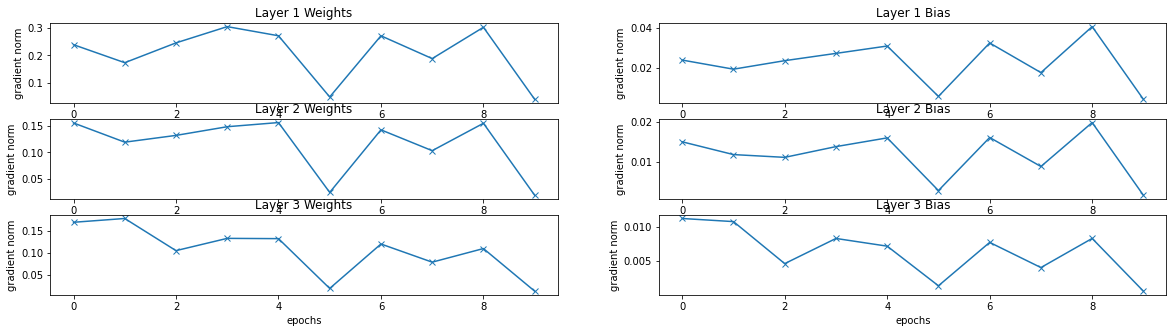



Training with SGD Optimizer and Weight regularized:
Epoch [0], val_loss: 1.6316, val_acc: 0.8365
Epoch [1], val_loss: 1.5513, val_acc: 0.9170
Epoch [2], val_loss: 1.5363, val_acc: 0.9311
Epoch [3], val_loss: 1.5229, val_acc: 0.9432
Epoch [4], val_loss: 1.5184, val_acc: 0.9476
Epoch [0], val_loss: 1.5112, val_acc: 0.9536
Epoch [1], val_loss: 1.5104, val_acc: 0.9539
Epoch [2], val_loss: 1.5093, val_acc: 0.9551
Epoch [3], val_loss: 1.5085, val_acc: 0.9563
Epoch [4], val_loss: 1.5075, val_acc: 0.9576


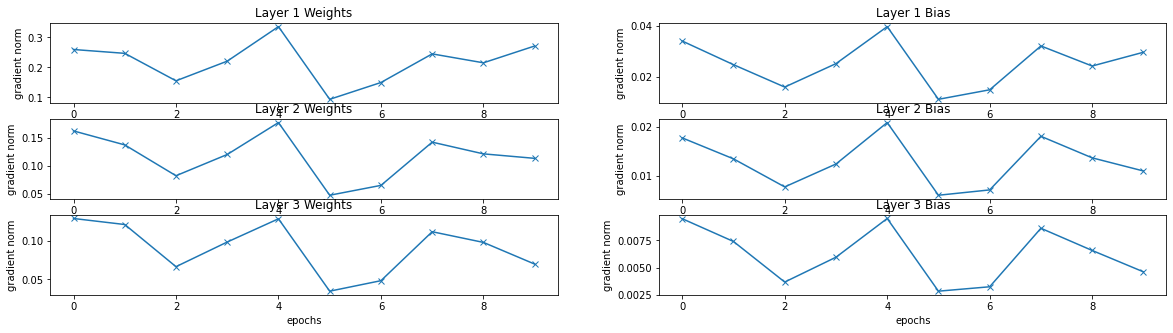

In [ ]:
##################################################
#Plots without skip connections
##################################################

class reLUModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 512)
        # output layer
        self.linear3 = nn.Linear(512, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

weight_reg = 1e-4

def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    l1gradients = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        gradient_norms = np.array([])
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            gradient_norms = np.array([[torch.linalg.norm(model.linear1.weight.grad), torch.linalg.norm(model.linear1.bias.grad)],
                              [torch.linalg.norm(model.linear2.weight.grad), torch.linalg.norm(model.linear2.bias.grad)],
                               [torch.linalg.norm(model.linear3.weight.grad), torch.linalg.norm(model.linear3.bias.grad)]])
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        l1gradients.append(gradient_norms)

    return history, l1gradients

print("\n\nTraining with SGD Optimizer and without weight regularized:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
gradients = []
# with learning rate : 0.5
hist, grads = fit(5, 0.5, model, train_loader, val_loader)
history += hist
gradients += grads
# with learning rate : 0.1
hist, grads = fit(5, 0.1, model, train_loader, val_loader)
history += hist
gradients += grads

losses = [x['val_loss'] for x in history]

first_layer_weights_grad = []
first_layer_bias_grad = []
second_layer_weights_grad = []
second_layer_bias_grad = []
third_layer_weights_grad = []
third_layer_bias_grad = []


for i in range(np.array(gradients).shape[0]):
  first_layer_weights_grad += [gradients[i][0][0]]
  first_layer_bias_grad += [gradients[i][0][1]]
  second_layer_weights_grad += [gradients[i][1][0]]
  second_layer_bias_grad += [gradients[i][1][1]]
  third_layer_weights_grad += [gradients[i][2][0]]
  third_layer_bias_grad += [gradients[i][2][1]]

plt.figure(figsize = (20,5))

plt.subplot(3,2,1)
plt.plot(first_layer_weights_grad, '-x')
plt.title('Layer 1 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,2)
plt.plot(first_layer_bias_grad, '-x')
plt.title('Layer 1 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,3)
plt.plot(second_layer_weights_grad, '-x')
plt.title('Layer 2 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,4)
plt.plot(second_layer_bias_grad, '-x')
plt.title('Layer 2 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,5)
plt.plot(third_layer_weights_grad, '-x')
plt.title('Layer 3 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,6)
plt.plot(third_layer_bias_grad, '-x')
plt.title('Layer 3 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.show()

print("\n\nTraining with SGD Optimizer and Weight regularized:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
gradients = []
# with learning rate : 0.5
hist, grads = fit(5, 0.5, model, train_loader, val_loader, weight_decay=weight_reg)
history += hist
gradients += grads
# with learning rate : 0.1
hist, grads = fit(5, 0.1, model, train_loader, val_loader, weight_decay=weight_reg)
history += hist
gradients += grads

losses = [x['val_loss'] for x in history]

first_layer_weights_grad = []
first_layer_bias_grad = []
second_layer_weights_grad = []
second_layer_bias_grad = []
third_layer_weights_grad = []
third_layer_bias_grad = []


for i in range(np.array(gradients).shape[0]):
  first_layer_weights_grad += [gradients[i][0][0]]
  first_layer_bias_grad += [gradients[i][0][1]]
  second_layer_weights_grad += [gradients[i][1][0]]
  second_layer_bias_grad += [gradients[i][1][1]]
  third_layer_weights_grad += [gradients[i][2][0]]
  third_layer_bias_grad += [gradients[i][2][1]]

plt.figure(figsize = (20,5))

plt.subplot(3,2,1)
plt.plot(first_layer_weights_grad, '-x')
plt.title('Layer 1 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,2)
plt.plot(first_layer_bias_grad, '-x')
plt.title('Layer 1 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,3)
plt.plot(second_layer_weights_grad, '-x')
plt.title('Layer 2 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,4)
plt.plot(second_layer_bias_grad, '-x')
plt.title('Layer 2 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,5)
plt.plot(third_layer_weights_grad, '-x')
plt.title('Layer 3 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(3,2,6)
plt.plot(third_layer_bias_grad, '-x')
plt.title('Layer 3 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.show()



Training with SGD Optimizer ,without weight regularized and with skip connections:
Epoch [0], val_loss: 1.6213, val_acc: 0.8438
Epoch [1], val_loss: 1.5438, val_acc: 0.9241
Epoch [2], val_loss: 1.5208, val_acc: 0.9440
Epoch [3], val_loss: 1.5097, val_acc: 0.9550
Epoch [4], val_loss: 1.5052, val_acc: 0.9591
Epoch [0], val_loss: 1.4981, val_acc: 0.9658
Epoch [1], val_loss: 1.4963, val_acc: 0.9669
Epoch [2], val_loss: 1.4959, val_acc: 0.9670
Epoch [3], val_loss: 1.4949, val_acc: 0.9684
Epoch [4], val_loss: 1.4942, val_acc: 0.9687
{'val_loss': 1.4923734664916992, 'val_acc': 0.9701172113418579}


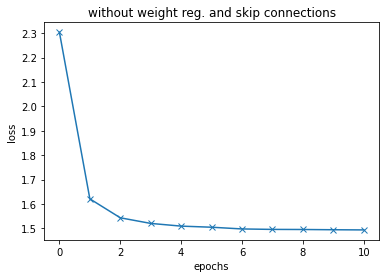

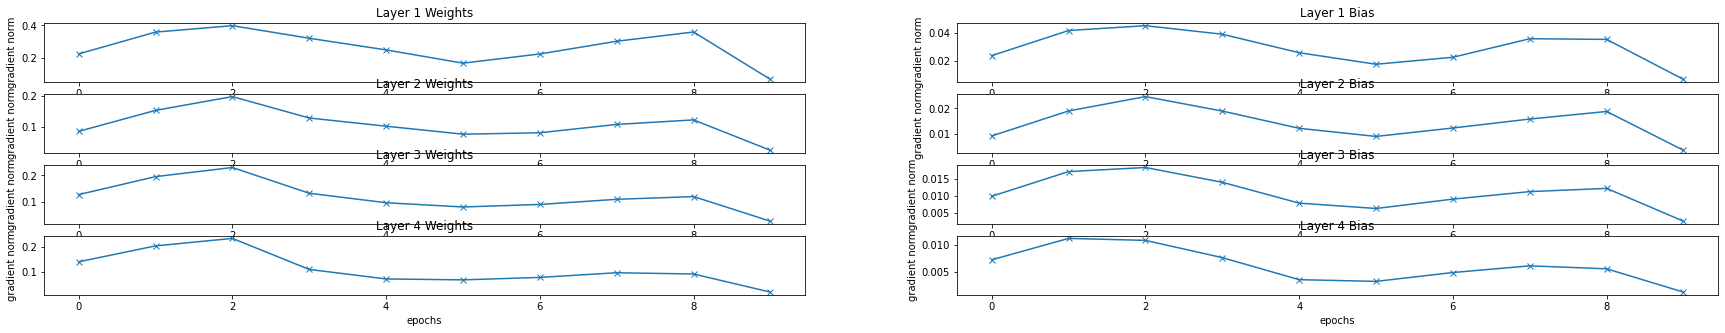



Training with SGD Optimizer, Weight regularized and with skip connections:
Epoch [0], val_loss: 1.5967, val_acc: 0.8754
Epoch [1], val_loss: 1.5370, val_acc: 0.9286
Epoch [2], val_loss: 1.5186, val_acc: 0.9462
Epoch [3], val_loss: 1.5086, val_acc: 0.9559
Epoch [4], val_loss: 1.5043, val_acc: 0.9601
Epoch [0], val_loss: 1.4983, val_acc: 0.9655
Epoch [1], val_loss: 1.4975, val_acc: 0.9666
Epoch [2], val_loss: 1.4958, val_acc: 0.9690
Epoch [3], val_loss: 1.4955, val_acc: 0.9691
Epoch [4], val_loss: 1.4942, val_acc: 0.9698
{'val_loss': 1.492128849029541, 'val_acc': 0.9715820550918579}


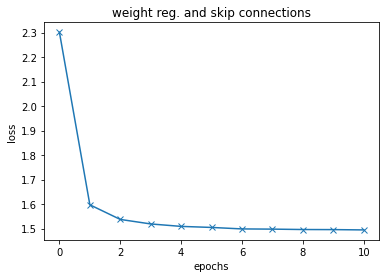

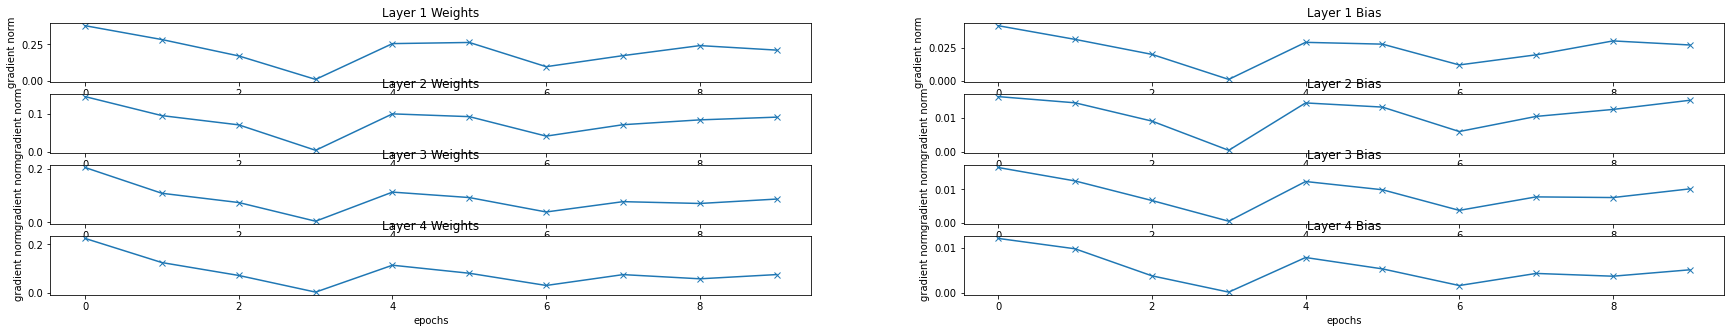

In [ ]:
##################################################
#Plots with skip connections
##################################################


class reLUModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 512)
        # hidden layer 3
        self.linear3 = nn.Linear(512, 512)
        # output layer
        self.linear4 = nn.Linear(512, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        skip = out
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        out = out + skip
        # Get intermediate outputs using hidden layer 3
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)
        out = out + skip
        # Get predictions using output layer
        out = self.linear4(out)
        # Apply activation function
        out = F.softmax(out, dim=1)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

weight_reg = 1e-4

def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    l1gradients = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        gradient_norms = np.array([])
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            gradient_norms = np.array([[torch.linalg.norm(model.linear1.weight.grad), torch.linalg.norm(model.linear1.bias.grad)],
                              [torch.linalg.norm(model.linear2.weight.grad), torch.linalg.norm(model.linear2.bias.grad)],
                               [torch.linalg.norm(model.linear3.weight.grad), torch.linalg.norm(model.linear3.bias.grad)],
                               [torch.linalg.norm(model.linear4.weight.grad), torch.linalg.norm(model.linear4.bias.grad)]])
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        l1gradients.append(gradient_norms)

    return history, l1gradients

print("\n\nTraining with SGD Optimizer ,without weight regularized and with skip connections:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
gradients = []
# with learning rate : 0.5
hist, grads = fit(5, 0.5, model, train_loader, val_loader)
history += hist
gradients += grads
# with learning rate : 0.1
hist, grads = fit(5, 0.1, model, train_loader, val_loader)
history += hist
gradients += grads

losses = [x['val_loss'] for x in history]
print(evaluate(model, test_loader))

plt.figure()
plt.plot(losses, '-x')
plt.title('without weight reg. and skip connections')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

first_layer_weights_grad = []
first_layer_bias_grad = []
second_layer_weights_grad = []
second_layer_bias_grad = []
third_layer_weights_grad = []
third_layer_bias_grad = []
fourth_layer_weights_grad = []
fourth_layer_bias_grad = []


for i in range(np.array(gradients).shape[0]):
  first_layer_weights_grad += [gradients[i][0][0]]
  first_layer_bias_grad += [gradients[i][0][1]]
  second_layer_weights_grad += [gradients[i][1][0]]
  second_layer_bias_grad += [gradients[i][1][1]]
  third_layer_weights_grad += [gradients[i][2][0]]
  third_layer_bias_grad += [gradients[i][2][1]]
  fourth_layer_weights_grad += [gradients[i][3][0]]
  fourth_layer_bias_grad += [gradients[i][3][1]]

plt.figure(figsize = (30,5))

plt.subplot(4,2,1)
plt.plot(first_layer_weights_grad, '-x')
plt.title('Layer 1 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,2)
plt.plot(first_layer_bias_grad, '-x')
plt.title('Layer 1 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,3)
plt.plot(second_layer_weights_grad, '-x')
plt.title('Layer 2 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,4)
plt.plot(second_layer_bias_grad, '-x')
plt.title('Layer 2 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,5)
plt.plot(third_layer_weights_grad, '-x')
plt.title('Layer 3 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,6)
plt.plot(third_layer_bias_grad, '-x')
plt.title('Layer 3 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,7)
plt.plot(fourth_layer_weights_grad, '-x')
plt.title('Layer 4 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,8)
plt.plot(fourth_layer_bias_grad, '-x')
plt.title('Layer 4 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.show()

print("\n\nTraining with SGD Optimizer, Weight regularized and with skip connections:")
model = reLUModel(input_size, out_size=num_classes)

to_device(model, device)

history = [evaluate(model, val_loader)]
gradients = []
# with learning rate : 0.5
hist, grads = fit(5, 0.5, model, train_loader, val_loader, weight_decay=weight_reg)
history += hist
gradients += grads
# with learning rate : 0.1
hist, grads = fit(5, 0.1, model, train_loader, val_loader, weight_decay=weight_reg)
history += hist
gradients += grads

losses = [x['val_loss'] for x in history]
print(evaluate(model, test_loader))

plt.figure()
plt.plot(losses, '-x')
plt.title('weight reg. and skip connections')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

first_layer_weights_grad = []
first_layer_bias_grad = []
second_layer_weights_grad = []
second_layer_bias_grad = []
third_layer_weights_grad = []
third_layer_bias_grad = []
fourth_layer_weights_grad = []
fourth_layer_bias_grad = []


for i in range(np.array(gradients).shape[0]):
  first_layer_weights_grad += [gradients[i][0][0]]
  first_layer_bias_grad += [gradients[i][0][1]]
  second_layer_weights_grad += [gradients[i][1][0]]
  second_layer_bias_grad += [gradients[i][1][1]]
  third_layer_weights_grad += [gradients[i][2][0]]
  third_layer_bias_grad += [gradients[i][2][1]]
  fourth_layer_weights_grad += [gradients[i][3][0]]
  fourth_layer_bias_grad += [gradients[i][3][1]]

plt.figure(figsize = (30,5))

plt.subplot(4,2,1)
plt.plot(first_layer_weights_grad, '-x')
plt.title('Layer 1 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,2)
plt.plot(first_layer_bias_grad, '-x')
plt.title('Layer 1 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,3)
plt.plot(second_layer_weights_grad, '-x')
plt.title('Layer 2 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,4)
plt.plot(second_layer_bias_grad, '-x')
plt.title('Layer 2 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,5)
plt.plot(third_layer_weights_grad, '-x')
plt.title('Layer 3 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,6)
plt.plot(third_layer_bias_grad, '-x')
plt.title('Layer 3 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,7)
plt.plot(fourth_layer_weights_grad, '-x')
plt.title('Layer 4 Weights')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.subplot(4,2,8)
plt.plot(fourth_layer_bias_grad, '-x')
plt.title('Layer 4 Bias')
plt.xlabel('epochs')
plt.ylabel('gradient norm')

plt.show()


In [ ]:
##################################################
#Observations
##################################################
#below text!

## Observations

From above data, we can observe that model generalizes well with skip connections (i.e reduced overfitting) by giving validation accuracy of around 97%. From the plots for with and without weight decay, we can say weights and bias increases & decreases in a regularized way by monitoring their norms and including them as a penalty term to overall loss functions. 